In [1]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano

from keras.datasets import cifar10
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

# this is the size of our encoded representations
#encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
#encoding_dim = 3
encoding_dim = 700


# this is our input placeholder
input_img = Input(shape=(3072,))

# "encoded" is the encoded representation of the input using relu
encoded = Dense(2800, activation='relu')(input_img)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(1700, activation='relu')(encoded)
encoded = Dense(1200, activation='relu')(encoded)
encoded = Dense(1000, activation='relu')(encoded)
encoded = Dense(800, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# "encoded" is the encoded representation of the input using softmax
"""
encoded = Dense(2800, activation='softmax')(input_img)
encoded = Dense(2000, activation='softmax')(encoded)
encoded = Dense(1700, activation='softmax')(encoded)
encoded = Dense(1200, activation='softmax')(encoded)
encoded = Dense(1000, activation='softmax')(encoded)
encoded = Dense(800, activation='softmax')(encoded)
encoded = Dense(encoding_dim, activation='softmax')(encoded)
"""
# "decoded" is the lossy reconstruction of the input
decoded = Dense(3072, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)


Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)
Using Theano backend.


In [2]:
print (encoding_dim)
print (input_img)
print (encoded)
print (decoded)
print (autoencoder)

600
input_1
Elemwise{mul,no_inplace}.0
sigmoid.0


In [3]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

In [4]:
print (encoder)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [6]:
print (encoded_input)
print (decoder_layer)
print (decoder)

input_2


In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [9]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(len(x_train))
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)


50000
(50000, 3072)
(10000, 3072)
(50000, 1)
(10000, 1)


In [11]:
#random_state = 121
#s_train, s_valid = train_test_split(x_train, test_size=0.3, random_state=random_state)

In [12]:
noise_factor = 0.2
s_train_noisy = s_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_train.shape) 
s_valid_noisy = s_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_valid.shape) 

s_train_noisy = np.clip(s_train_noisy, 0., 1.)
s_valid_noisy = np.clip(s_valid_noisy, 0., 1.)
print (s_train_noisy.shape)

(35000, 3072)


(35000, 3, 32, 32)


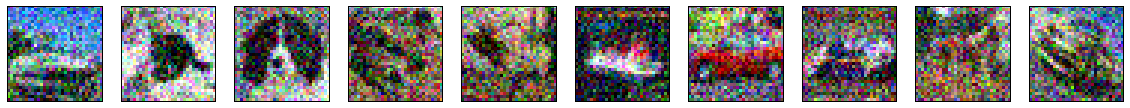

In [13]:
s_train_noisy=s_train_noisy.reshape(35000,3,32,32)
print (s_train_noisy.shape)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    #ax = plt.subplot(1, n, i)
    #Plot the raw original image
    plt.imshow(np.transpose(s_train_noisy[i], (1, 2, 0)), interpolation='nearest')    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
     
plt.show()

In [14]:
s_train_noisy = s_train_noisy.reshape((len(s_train_noisy), np.prod(s_train_noisy.shape[1:])))
print (s_train_noisy.shape)
print (s_train.shape)
print (s_valid_noisy.shape)
print (s_valid.shape)


(35000, 3072)
(35000, 3072)
(15000, 3072)
(15000, 3072)


In [11]:
nfold=5
nb_epoch=50
batch_size=256
random_state =1236

In [12]:
kfold_weights_path = os.path.join('weights_kfold_' + str(nfold) + '.h5')
print(kfold_weights_path)

weights_kfold_5.h5


In [13]:
callbacks = [
                EarlyStopping(monitor='val_loss', patience=0, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
            ]

#callbacks = [
#                EarlyStopping(monitor='val_loss', patience=1, verbose=0)
#            ]

In [14]:
kf = KFold(len(x_train), n_folds=nfold, shuffle=True, random_state=random_state)
print(kf)

sklearn.cross_validation.KFold(n=50000, n_folds=5, shuffle=True, random_state=1236)


In [15]:
full_encoded_imgs = np.zeros(shape=[x_test.shape[0],encoding_dim])
full_decoded_imgs = np.zeros(shape=[x_test.shape[0],x_train.shape[1]])
print(full_encoded_imgs.shape)
print(full_decoded_imgs.shape)

(10000, 600)
(10000, 3072)


In [17]:
num_fold = 0
for train_index,valid_index in kf:
    s_train,s_valid  = x_train[train_index], x_train[valid_index]
    
    noise_factor = 0.2
    s_train_noisy = s_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_train.shape) 
    s_valid_noisy = s_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_valid.shape) 

    s_train_noisy = np.clip(s_train_noisy, 0., 1.)
    s_valid_noisy = np.clip(s_valid_noisy, 0., 1.)
    #y_train, y_test = y[train_index], y[test_index]
    
    num_fold += 1
    print('\n\nStart KFold number {} from {}'.format(num_fold, nfold))
    print('Split train: ', len(s_train_noisy), len(s_train))
    print('Split valid: ', len(s_valid_noisy), len(s_valid))
        
    autoencoder.fit(s_train_noisy, s_train,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(s_valid_noisy, s_valid),
                callbacks=callbacks)
    
    # Store test predictions
    encoded_imgs = encoder.predict(x_test,batch_size=batch_size, verbose=1)
    #full_encoded_imgs = np.vstack([full_encoded_imgs,encoded_imgs])
    full_encoded_imgs = np.add(full_encoded_imgs,encoded_imgs)
    #full_encoded_imgs.append(encoded_imgs)
    #print(full_encoded_imgs.shape)
    
    decoded_imgs = decoder.predict(encoded_imgs,batch_size=batch_size, verbose=1)
    #full_decoded_imgs = np.vstack([full_decoded_imgs,decoded_imgs])
    full_decoded_imgs = np.add(full_decoded_imgs,decoded_imgs)

    #full_decoded_imgs.append(decoded_imgs)
    #print(full_decoded_imgs.shape)





Start KFold number 1 from 5
Split train:  40000 40000
Split valid:  10000 10000
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 46s - loss: 0.6469 - val_loss: 0.6430
Epoch 2/50
40000/40000 [==============================] - 47s - loss: 0.6434 - val_loss: 0.6425
Epoch 3/50
40000/40000 [==============================] - 47s - loss: 0.6409 - val_loss: 0.6363
Epoch 4/50
40000/40000 [==============================] - 47s - loss: 0.6390 - val_loss: 0.6359
Epoch 5/50
10000/10000 [==============================] - 0s     


Start KFold number 2 from 5
Split train:  40000 40000
Split valid:  10000 10000
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 0s     


Start KFold number 3 from 5
Split train:  40000 40000
Split valid:  10000 10000
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 49s - loss: 0.6357 - val_loss:

In [18]:
print(full_encoded_imgs.shape)
print(full_decoded_imgs.shape)

(10000, 600)
(10000, 3072)


In [19]:
res_encoded_imgs = full_encoded_imgs/nfold
res_decoded_imgs = full_decoded_imgs/nfold
print(res_encoded_imgs.shape)
print(res_decoded_imgs.shape)

(10000, 600)
(10000, 3072)


In [17]:
"""
autoencoder.fit(s_train_noisy, s_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                verbose=1,
                validation_data=(s_valid_noisy, s_valid),
                callbacks=callbacks)
"""

Train on 35000 samples, validate on 15000 samples
Epoch 1/50
35000/35000 [==============================] - 46s - loss: 0.6931 - val_loss: 0.6931
Epoch 2/50
35000/35000 [==============================] - 46s - loss: 0.6930 - val_loss: 0.6930
Epoch 3/50
35000/35000 [==============================] - 46s - loss: 0.6929 - val_loss: 0.6929
Epoch 4/50
35000/35000 [==============================] - 46s - loss: 0.6928 - val_loss: 0.6928
Epoch 5/50
35000/35000 [==============================] - 46s - loss: 0.6927 - val_loss: 0.6927
Epoch 6/50
35000/35000 [==============================] - 46s - loss: 0.6926 - val_loss: 0.6926
Epoch 7/50
35000/35000 [==============================] - 46s - loss: 0.6925 - val_loss: 0.6925
Epoch 8/50
35000/35000 [==============================] - 46s - loss: 0.6924 - val_loss: 0.6924
Epoch 9/50
35000/35000 [==============================] - 46s - loss: 0.6924 - val_loss: 0.6923
Epoch 10/50
35000/35000 [==============================] - 46s - loss: 0.6923 - val_lo

In [18]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
print (encoded_imgs.size)
print (encoded_imgs.shape)
print (encoded_imgs.nbytes)


decoded_imgs = decoder.predict(encoded_imgs)
print (decoded_imgs.size)
print (decoded_imgs.shape)
print (decoded_imgs.nbytes)

6000000
(10000, 600)
48000000
30720000
(10000, 3072)
245760000


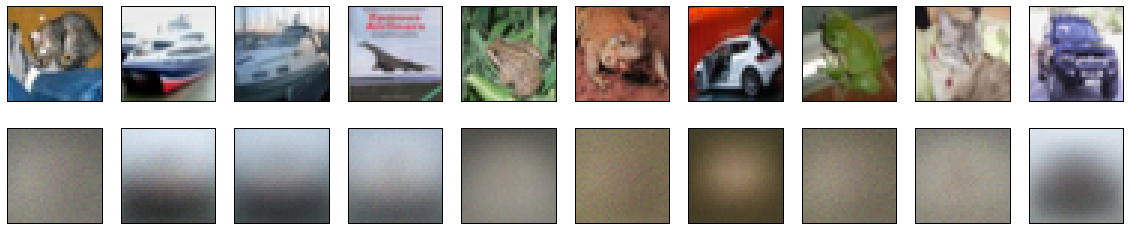

In [20]:
import matplotlib.pyplot as plt
res_decoded_imgs=res_decoded_imgs.reshape(10000,3,32,32)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    #ax = plt.subplot(1, n, i)
    #Plot the raw original image
    plt.imshow(np.transpose(X_test[i], (1, 2, 0)), interpolation='nearest')    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.transpose(res_decoded_imgs[i], (1, 2, 0)), interpolation='nearest')    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [21]:
#Predict the digits using a classifier
#Use the reduce Encoded train and test images
encoded_train_imgs = encoder.predict(x_train)
print (encoded_train_imgs.size)
print (encoded_train_imgs.shape)
print (encoded_train_imgs.nbytes)
print (y_train.shape)

30000000
(50000, 600)
240000000
(50000, 1)


In [22]:
encoded_test_imgs = encoder.predict(x_test)
print (encoded_test_imgs.size)
print (encoded_test_imgs.shape)
print (encoded_test_imgs.nbytes)
print (y_test.shape)

6000000
(10000, 600)
48000000
(10000, 1)


In [23]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf = clf.fit(encoded_train_imgs, np.ravel(y_train))

In [24]:
y_pred = clf.predict(encoded_test_imgs)


In [25]:
num=len(encoded_test_imgs)
r=0
w=0
y_test = np.ravel(y_test)
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")


tested  10000 digits
correct:  2570 wrong:  7430 error rate:  74.3 %
got correctly  25.7 %
